# Anomaly Detection in Slovak Parliamentary Transcripts

This notebook evaluates the effectiveness of various embedding models and anomaly detection algorithms on Slovak parliamentary transcripts (2020–2023). The corpus includes columns such as 'tlac', 'schodza', 'prepis', 'druh_vystupenia', 'poslanec', 'klub', 'obdobie', 'Date', 'StartTime', 'koalicia', 'truncated_prepis', and multiple embedding columns.

## Methodology

1. Thematic groups are created, filtering speeches to “Speech in the debate”.
2. For each group, 3% of items from a thematically different debate are included.
3. Outlier-detection algorithms (k-NN, INNE, ECOD, Isolation Forest, DBSCAN, One-Class SVM, LOF, COPOD) are tested for each embedding vector.
4. Outlier identification is performed across a mixed set of items.
5. Clustering is performed using k-means.

## Output

- Performance metrics (ROC-AUC, PR-AUC, Recall, Precision, F1) are calculated for each detector and embedding.
- Top-performing detectors per embedding are summarized and visualized.
- Results are saved to the `graphs` directory for further analysis.

*This approach demonstrates novel procedures for evaluating NLP models on real-world political discourse in Slovak language.*

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
from typing import List, Callable, Dict, Union
from pyod.models.lof   import LOF
from pyod.models.copod import COPOD
import random
from sklearn.manifold import TSNE
from pyod.models.inne import INNE
from pyod.models.ecod import ECOD
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM

from tqdm.auto import tqdm
from ipywidgets import Dropdown, Output, VBox
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score,f1_score
)


import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata

import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata as ud


In [2]:
df = pd.read_parquet(r"..\data\df_to_app_with_openAI_S_L_voyage_gdoogle_mistral_embeddings_navrh_zakona_obdobie_8_core_clear.parquet", engine="fastparquet")

In [3]:
ID_COL        = "prepis"            # unique speech ID
MINISTRY_COL  = "Predkladateľ"

In [4]:
df.Predkladateľ.value_counts()

Predkladateľ
Ministerstvo zdravotníctva SR                          111
Ministerstvo spravodlivosti SR                          82
Ministerstvo práce, sociálnych vecí a rodiny SR         78
Ministerstvo vnútra SR                                  67
Ministerstvo hospodárstva SR                            38
Ministerstvo dopravy SR                                 34
Ministerstvo kultúry SR                                 27
Ministerstvo životného prostredia SR                    27
Ministerstvo obrany SR                                  21
Ministerstvo pôdohospodárstva a rozvoja vidieka SR      19
Ministerstvo školstva, výskumu, vývoja a mládeže SR     18
Name: count, dtype: int64

In [5]:
# ─── 1 · ALL detector wrappers, cleaned ──────────────────────────────
INJECT_FRAC = 0.05   # 5 % intruders
K_KNN       = 30     # neighbourhood for k‑distance
CONTAM      = INJECT_FRAC
RNG         = npr.default_rng(42)

def score_knn(X: np.ndarray, k: int = K_KNN) -> np.ndarray:
    """k‑distance score (high = lonelier).  Caps *k* at N‑1 if sample is small."""
    k_use = max(1, min(k, len(X) - 1))  # ensure n_neighbors ≤ n_samples‑1
    nn = NearestNeighbors(n_neighbors=k_use + 1, metric="cosine", algorithm="brute", n_jobs=-1)
    nn.fit(X)
    return nn.kneighbors(X, return_distance=True)[0][:, -1]


def score_inne(X: np.ndarray, contamination: float = CONTAM) -> np.ndarray:
    mdl = INNE(n_estimators=5, contamination=contamination, random_state=42)  # PyOD ≥1.1.0 has no n_jobs arg
    mdl.fit(X)
    return mdl.decision_scores_


def score_ecod(X: np.ndarray, contamination: float = CONTAM) -> np.ndarray:
    mdl = ECOD(contamination=contamination)
    mdl.fit(X)
    return mdl.decision_scores_


def score_lof(X: np.ndarray, k: int = K_KNN) -> np.ndarray:
    """Local Outlier Factor with safety‑capped k."""
    k_use = max(1, min(k, len(X) - 1))
    mdl = LOF(n_neighbors=k_use)
    mdl.fit(X)
    return mdl.decision_scores_


def score_copod(X: np.ndarray) -> np.ndarray:
    """COPOD – parameter‑free copula‑based OD."""
    mdl = COPOD()
    mdl.fit(X)
    return mdl.decision_scores_


def score_iforest(X: np.ndarray, contamination: float = CONTAM) -> np.ndarray:
    mdl = IsolationForest(n_estimators=300, contamination=contamination, random_state=42)
    mdl.fit(X)
    return -mdl.score_samples(X)


def score_ocsvm(X: np.ndarray, nu: float = CONTAM) -> np.ndarray:
    mdl = OneClassSVM(kernel="rbf", nu=nu, gamma="scale")
    mdl.fit(X)
    return -mdl.decision_function(X)


def score_dbscan(X: np.ndarray, eps: float = 0.35, min_samples: int = 10) -> np.ndarray:
    mdl = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine", algorithm="brute").fit(X)
    return (mdl.labels_ == -1).astype(float)



# put the *new* functions in the list you loop over
SCORERS = {
    "kNN":        score_knn,
    "INNE":       score_inne,
    "ECOD":       score_ecod,
    "IForest":    score_iforest,
    "OC-SVM":     score_ocsvm,
    "DBSCAN":     score_dbscan,
    "LOF": score_lof, 
    "COPOD": score_copod
}


In [6]:
EMB_COLS = [
    "gemini-embedding-exp-03-07",
    "voyage-3-large_embeddings",
    "openAI_embedding_3076",
    "openAI_embedding_small",
    "mistral_embedings",
]

In [7]:
df.Predkladateľ.value_counts()

Predkladateľ
Ministerstvo zdravotníctva SR                          111
Ministerstvo spravodlivosti SR                          82
Ministerstvo práce, sociálnych vecí a rodiny SR         78
Ministerstvo vnútra SR                                  67
Ministerstvo hospodárstva SR                            38
Ministerstvo dopravy SR                                 34
Ministerstvo kultúry SR                                 27
Ministerstvo životného prostredia SR                    27
Ministerstvo obrany SR                                  21
Ministerstvo pôdohospodárstva a rozvoja vidieka SR      19
Ministerstvo školstva, výskumu, vývoja a mládeže SR     18
Name: count, dtype: int64

In [7]:


def evaluate(scores: np.ndarray, y_true: np.ndarray, contam: float = CONTAM) -> dict:
    """Return ROC‑AUC, PR‑AUC, Recall@2 %FP, Precision/Recall/F1 at contamination cut."""
    roc  = roc_auc_score(y_true, scores)
    prc  = average_precision_score(y_true, scores)

    # recall at 2 % false‑positive rate
    top_n = int(0.02 * len(y_true))
    recall2p = y_true[np.argsort(-scores)][:top_n].sum() / y_true.sum()

    # threshold = (1‑contam) percentile of scores
    tau   = np.percentile(scores, 100 * (1 - contam))
    preds = scores >= tau
    rec   = recall_score(y_true, preds, zero_division=0)
    prec  = precision_score(y_true, preds, zero_division=0)
    f1    = f1_score(y_true, preds, zero_division=0)

    return dict(roc_auc=roc, pr_auc=prc, recall2p=recall2p,
                recall=rec, precision=prec, f1=f1)

In [8]:
TOPIC_PAIRS = [ (x,y) for x in df.Predkladateľ.unique() for y in df.Predkladateľ.unique() if x != y ]

In [9]:
len(TOPIC_PAIRS)

110

In [10]:
results = []

for base_m, inj_m in TOPIC_PAIRS:                      
    base_df = df[df[MINISTRY_COL] == base_m]
    inj_df  = df[df[MINISTRY_COL] == inj_m]
    if base_df.empty or inj_df.empty:
        continue

    n_inj = max(1, int(INJECT_FRAC * len(base_df)))    
    inj_rows = inj_df.sample(n=n_inj, random_state=RNG.integers(1e9))
    mix_df   = pd.concat([base_df, inj_rows], ignore_index=True)

    y_true = np.zeros(len(mix_df), dtype=int)
    y_true[-n_inj:] = 1                                 

    contam_run = n_inj / len(mix_df)

    for emb_col in EMB_COLS:
        X = np.vstack(mix_df[emb_col].values).astype("float32")

        for det_name, scorer in SCORERS.items():
            if det_name in {"kNN", "LOF"}:
                scores = scorer(X, k=K_KNN)
            elif det_name == "OC-SVM":
                scores = scorer(X, nu=contam_run)
            elif det_name == "DBSCAN":
                scores = scorer(X)
            elif det_name == "COPOD":
                scores = scorer(X)
            else:
                scores = scorer(X, contamination=contam_run)

            metrics = evaluate(scores, y_true, contam=contam_run)
            results.append(dict(
                base=base_m, intruder=inj_m,
                embedding=emb_col, detector=det_name,
                **metrics
            ))

results_df = pd.DataFrame(results)
display(results_df.head())

c:\Users\alexe\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\alexe\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\alexe\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\alexe\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\alexe\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

,base,intruder,embedding,detector,roc_auc,pr_auc,recall2p,recall,precision,f1
0,Ministerstvo spravodlivosti SR,Ministerstvo kultúry SR,gemini-embedding-exp-03-07,kNN,0.762195,0.129997,0.00,0.00,0.000,0.00
1,Ministerstvo spravodlivosti SR,Ministerstvo kultúry SR,gemini-embedding-exp-03-07,INNE,0.763720,0.111694,0.00,0.50,0.125,0.20
2,Ministerstvo spravodlivosti SR,Ministerstvo kultúry SR,gemini-embedding-exp-03-07,ECOD,0.777439,0.122972,0.00,0.00,0.000,0.00
3,Ministerstvo spravodlivosti SR,Ministerstvo kultúry SR,gemini-embedding-exp-03-07,IForest,0.704268,0.091883,0.00,0.00,0.000,0.00
4,Ministerstvo spravodlivosti SR,Ministerstvo kultúry SR,gemini-embedding-exp-03-07,OC-SVM,0.884146,0.446429,0.25,0.25,0.250,0.25


In [12]:
def summarize_top3_f1(results_df: pd.DataFrame, agg: str = "mean") -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Summarize top-3 detectors per embedding by F1 score for Slovak parliamentary transcripts.
    
    Args:
        results_df: Results from anomaly detection experiments on parliamentary data
        agg: Aggregation method - "mean" or "median"
    
    Returns:
        summary_per_emb_f1: Summary statistics per embedding
        top3_per_emb_f1: Top-3 detectors per embedding with MAD error bars
    """
    if results_df.empty:
        raise ValueError("results_df is empty - no anomaly detection results to analyze")
    
    # Group by embedding and detector, compute statistics across all ministry pairs
    stats = results_df.groupby(["embedding", "detector"], as_index=False).agg({
        "f1": ["mean", "median", "std", lambda x: np.median(np.abs(x - np.median(x)))]  # MAD
    }).round(4)
    
    # Flatten column names
    stats.columns = ["embedding", "detector", "mean_f1", "median_f1", "std_f1", "mad_f1"]
    
    # Summary per embedding (overall performance)
    summary_per_emb_f1 = stats.groupby("embedding", as_index=False).agg({
        "mean_f1": ["mean", "max", "min"],
        "median_f1": ["mean", "max", "min"],
        "std_f1": "mean",
        "mad_f1": "mean"
    }).round(4)
    
    # Flatten summary columns
    summary_per_emb_f1.columns = [
        "embedding", "avg_mean_f1", "max_mean_f1", "min_mean_f1",
        "avg_median_f1", "max_median_f1", "min_median_f1", 
        "avg_std_f1", "avg_mad_f1"
    ]
    
    # Top-3 detectors per embedding
    rank_col = "mean_f1" if agg == "mean" else "median_f1"
    top3_per_emb_f1 = (stats.sort_values(["embedding", rank_col], ascending=[True, False])
                           .groupby("embedding", as_index=False)
                           .head(3)
                           .reset_index(drop=True))
    
    print(f"=== Slovak Parliamentary Anomaly Detection Results ===")
    print(f"Analyzed {results_df['embedding'].nunique()} embedding models:")
    for emb in results_df['embedding'].unique():
        print(f"  • {emb}")
    print(f"Tested {results_df['detector'].nunique()} anomaly detectors across {len(results_df)} ministry pair experiments")
    print(f"Top-3 ranking by: {rank_col}")
    
    return summary_per_emb_f1, top3_per_emb_f1

=== Slovak Parliamentary Anomaly Detection Results ===
Analyzed 5 embedding models:
  • gemini-embedding-exp-03-07
  • voyage-3-large_embeddings
  • openAI_embedding_3076
  • openAI_embedding_small
  • mistral_embedings
Tested 8 anomaly detectors across 4400 ministry pair experiments
Top-3 ranking by: mean_f1


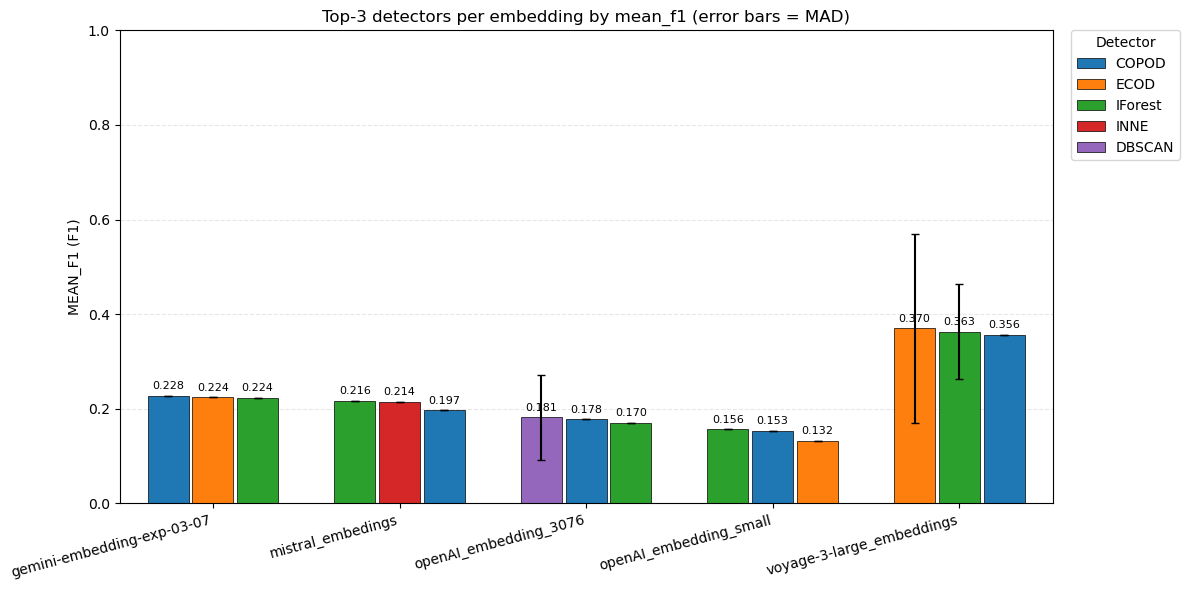

In [14]:
def plot_top3_bars_f1_matplotlib(top3_per_emb: pd.DataFrame, agg: str = "mean",
                                 figsize=(12, 6), bar_width=0.22, annotate=True):
    """
    Grouped bar chart of Top-3 detectors per embedding using matplotlib.
    Error bars = MAD (robust). Colors consistent per detector name.
    """
    if top3_per_emb.empty:
        raise ValueError("top3_per_emb is empty.")

    ycol = "mean_f1" if agg == "mean" else "median_f1"
    if ycol not in top3_per_emb.columns:
        raise ValueError(f"Column {ycol} not found in top3_per_emb.")

    # Sort for stable plotting
    dfp = top3_per_emb.copy()
    dfp = dfp.sort_values(["embedding", ycol], ascending=[True, False])

    # Unique embeddings in order
    embeddings = dfp["embedding"].drop_duplicates().tolist()
    x_centers = np.arange(len(embeddings))

    # Color map per detector (consistent across embeddings)
    detectors = dfp["detector"].drop_duplicates().tolist()
    cmap = plt.get_cmap("tab10")
    det2color = {d: cmap(i % 10) for i, d in enumerate(detectors)}

    # Up to 3 bars per embedding, centered
    max_bars = 3
    offsets = np.linspace(-(max_bars-1)/2, (max_bars-1)/2, max_bars) * (bar_width + 0.02)

    fig, ax = plt.subplots(figsize=figsize)

    handles_used = {}

    for i, emb in enumerate(embeddings):
        g = dfp[dfp["embedding"] == emb].head(max_bars).reset_index(drop=True)
        for j, row in g.iterrows():
            x = x_centers[i] + offsets[j]
            val = float(row[ycol])
            err = float(row.get("mad_f1", np.nan))
            det = row["detector"]
            color = det2color.get(det, "gray")

            h = ax.bar(x, val, width=bar_width, color=color, edgecolor="black",
                       linewidth=0.5, label=det if det not in handles_used else None,
                       yerr=err if np.isfinite(err) else None, capsize=3)

            if det not in handles_used:
                handles_used[det] = h

            if annotate and np.isfinite(val):
                ax.text(x, val + 0.01, f"{val:.3f}", ha="center", va="bottom", fontsize=8)

    ax.set_xticks(x_centers)
    ax.set_xticklabels(embeddings, rotation=15, ha="right")
    ax.set_xlim(-0.5, len(embeddings)-0.5)
    ax.set_ylim(0.0, 1.0)  # F1 in [0,1]
    ax.set_ylabel(f"{ycol.upper()} (F1)")
    ax.set_title(f"Top-3 detectors per embedding by {ycol} (error bars = MAD)")

    # ✅ fixed line:
    ax.yaxis.grid(True, linestyle="--", alpha=0.3)
    ax.set_axisbelow(True)

    ax.legend(title="Detector", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(r"..\graphs\top3_detectors_per_embedding_f1_matplotlib.png")
    plt.show()

summary_per_emb_f1, top3_per_emb_f1 = summarize_top3_f1(results_df, agg="mean")
plot_top3_bars_f1_matplotlib(top3_per_emb_f1, agg="mean")



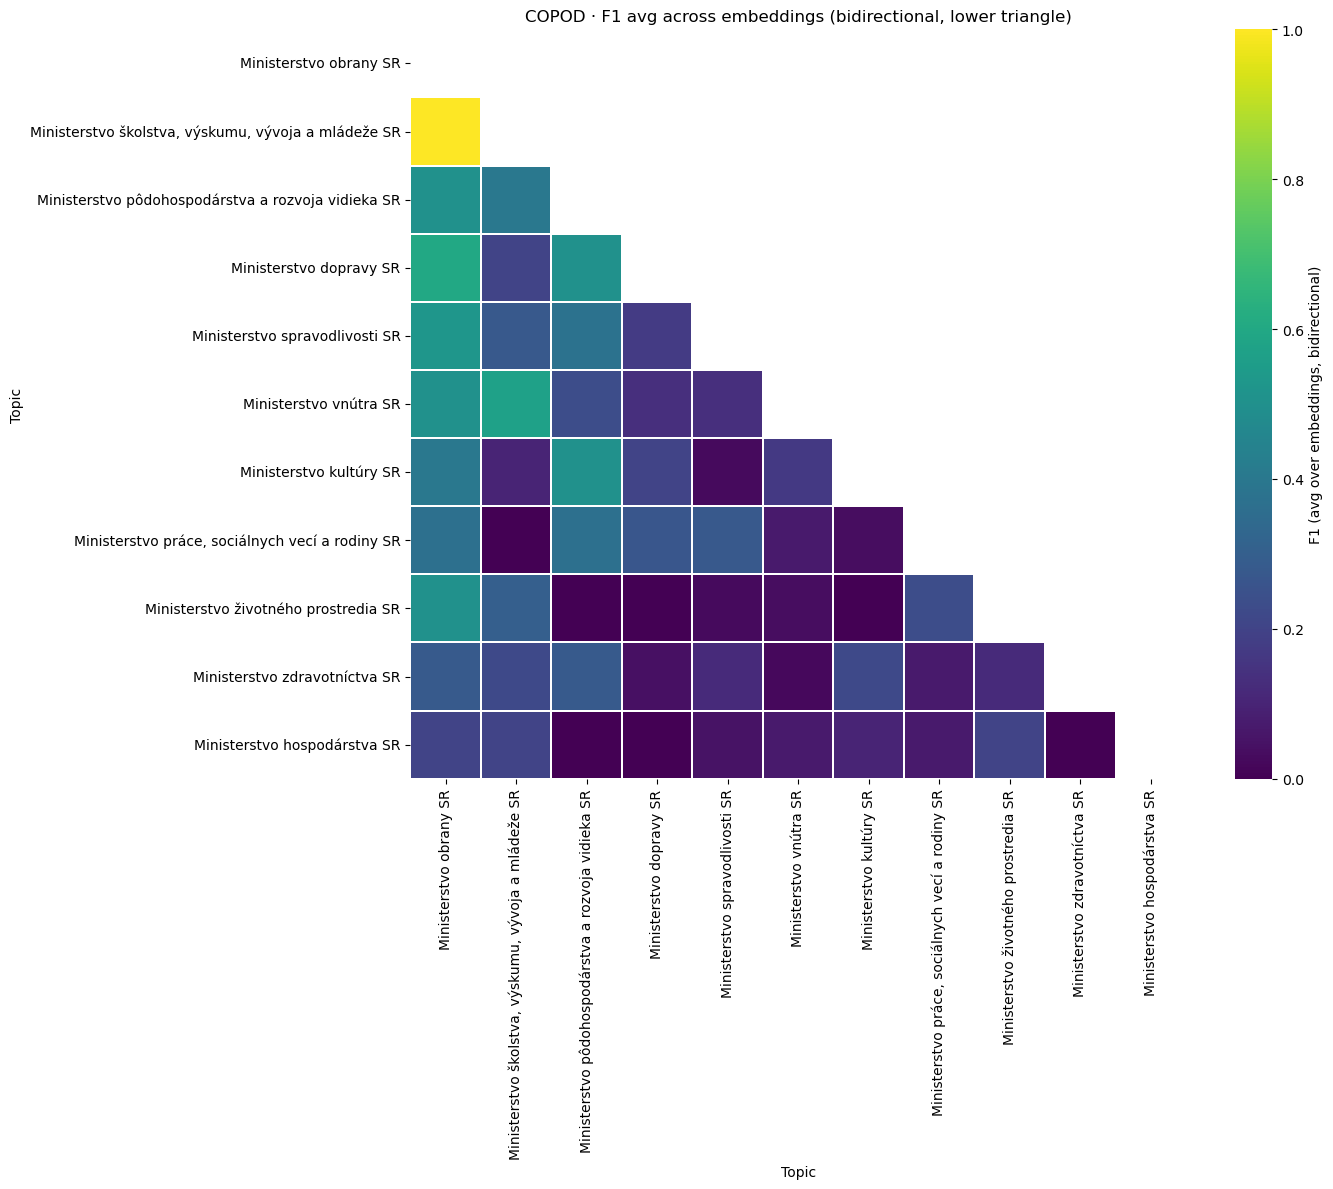

=== TOP 10 pairs (bidirectional, COPOD, F1 avg over embeddings) ===


,topic_A,topic_B,f1_bidir
32,Ministerstvo obrany SR,"Ministerstvo školstva, výskumu, vývoja a mláde...",1.0000
2,Ministerstvo dopravy SR,Ministerstvo obrany SR,0.6000
50,Ministerstvo vnútra SR,"Ministerstvo školstva, výskumu, vývoja a mláde...",0.5667
29,Ministerstvo obrany SR,Ministerstvo spravodlivosti SR,0.5250
4,Ministerstvo dopravy SR,Ministerstvo pôdohospodárstva a rozvoja vidiek...,0.5000
33,Ministerstvo obrany SR,Ministerstvo životného prostredia SR,0.5000
30,Ministerstvo obrany SR,Ministerstvo vnútra SR,0.5000
28,Ministerstvo obrany SR,Ministerstvo pôdohospodárstva a rozvoja vidiek...,0.5000
21,Ministerstvo kultúry SR,Ministerstvo pôdohospodárstva a rozvoja vidiek...,0.5000
19,Ministerstvo kultúry SR,Ministerstvo obrany SR,0.4000


=== BOTTOM 10 pairs (bidirectional, COPOD, F1 avg over embeddings) ===


,topic_A,topic_B,f1_bidir
0,Ministerstvo dopravy SR,Ministerstvo hospodárstva SR,0.000
44,Ministerstvo pôdohospodárstva a rozvoja vidiek...,Ministerstvo životného prostredia SR,0.000
26,Ministerstvo kultúry SR,Ministerstvo životného prostredia SR,0.000
38,"Ministerstvo práce, sociálnych vecí a rodiny SR","Ministerstvo školstva, výskumu, vývoja a mláde...",0.000
16,Ministerstvo hospodárstva SR,Ministerstvo zdravotníctva SR,0.000
13,Ministerstvo hospodárstva SR,Ministerstvo pôdohospodárstva a rozvoja vidiek...,0.000
9,Ministerstvo dopravy SR,Ministerstvo životného prostredia SR,0.000
49,Ministerstvo vnútra SR,Ministerstvo zdravotníctva SR,0.020
22,Ministerstvo kultúry SR,Ministerstvo spravodlivosti SR,0.025
48,Ministerstvo spravodlivosti SR,Ministerstvo životného prostredia SR,0.025


In [15]:
def _norm_topic(s: str) -> str:
    """Normalize labels to avoid duplicates (spaces, NBSP, Unicode)."""
    if pd.isna(s): return s
    s = str(s).replace("\u00A0", " ")         # NBSP -> space
    s = " ".join(s.split())                   # collapse whitespace
    s = ud.normalize("NFKC", s)               # Unicode compatibility normalization
    return s

def copod_f1_heatmap_bidirectional_lower(results_df: pd.DataFrame,
                                         title: str = "COPOD · F1 avg across embeddings (bidirectional, lower triangle)",
                                         top_k: int = 10,
                                         figsize=(14, 12),
                                         cmap="viridis"):
    # 1) Filter COPOD and clean labels
    df_c = results_df.query("detector == 'COPOD'").copy()
    if df_c.empty:
        raise ValueError("No COPOD rows found in results_df")

    df_c["base"]     = df_c["base"].map(_norm_topic)
    df_c["intruder"] = df_c["intruder"].map(_norm_topic)

    # 2) F1 per (embedding, base, intruder) then average across embeddings
    per_emb_pair = (df_c.groupby(["embedding","base","intruder"], as_index=False)["f1"]
                      .mean())
    pair_mean_over_emb = (per_emb_pair.groupby(["base","intruder"], as_index=False)["f1"]
                                      .mean()
                                      .rename(columns={"f1": "f1_mean_over_emb"}))

    # 3) Make bidirectional: average A→B and B→A into one undirected pair
    key = pair_mean_over_emb.apply(lambda r: tuple(sorted([r["base"], r["intruder"]])), axis=1)
    undir = (pair_mean_over_emb.assign(_key=key)
                                .groupby("_key", as_index=False)["f1_mean_over_emb"].mean())
    undir[["topic_A","topic_B"]] = undir["_key"].apply(lambda k: pd.Series([k[0], k[1]]))
    undir = undir.drop(columns=["_key"]).rename(columns={"f1_mean_over_emb":"f1_bidir"})

    # 4) Build symmetric matrix
    topics = sorted(set(undir["topic_A"]).union(undir["topic_B"]))
    idx = {t:i for i,t in enumerate(topics)}
    mat = np.full((len(topics), len(topics)), np.nan, float)
    for _, r in undir.iterrows():
        a, b, v = r["topic_A"], r["topic_B"], r["f1_bidir"]
        i, j = idx[a], idx[b]
        if a != b:
            mat[i, j] = v
            mat[j, i] = v

    # optional: order topics by average F1 (improves block structure)
    order = np.nanmean(mat, axis=1)
    order_idx = np.argsort(-order)  # descending
    mat = mat[order_idx][:, order_idx]
    topics_ordered = [topics[i] for i in order_idx]

    # 5) Mask upper triangle (and diagonal) to avoid duplicates visually
    mask = np.triu(np.ones_like(mat, dtype=bool), k=0)

    mat_df = pd.DataFrame(mat, index=topics_ordered, columns=topics_ordered)

    # 6) Plot heatmap (lower triangle only)
    plt.figure(figsize=figsize)
    ax = sns.heatmap(mat_df, mask=mask, cmap=cmap, vmin=0.0, vmax=1.0,
                     linewidths=0.2, linecolor="white",
                     cbar_kws={"label": "F1 (avg over embeddings, bidirectional)"},
                     square=False)
    ax.set_xlabel("Topic")
    ax.set_ylabel("Topic")
    ax.set_title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(r"..\graphs\copod_f1_heatmap_bidirectional_lower.png")
    plt.show()

    # 7) Top/Bottom pairs (bidirectional)
    top = undir.sort_values("f1_bidir", ascending=False).head(top_k).copy()
    bot = undir.sort_values("f1_bidir", ascending=True ).head(top_k).copy()

    print(f"=== TOP {top_k} pairs (bidirectional, COPOD, F1 avg over embeddings) ===")
    display(top[["topic_A","topic_B","f1_bidir"]].assign(f1_bidir=lambda d: d["f1_bidir"].round(4)))

    print(f"=== BOTTOM {top_k} pairs (bidirectional, COPOD, F1 avg over embeddings) ===")
    display(bot[["topic_A","topic_B","f1_bidir"]].assign(f1_bidir=lambda d: d["f1_bidir"].round(4)))

    return {"matrix_lower": mat_df, "pairs": undir, "top": top, "bottom": bot}


out = copod_f1_heatmap_bidirectional_lower(results_df)




